<center><img src="images/header.png"></center>

<h1><center>Лекция №6: Введение в анализ социальных сетей</center></h1>
<hr>
<h1><center>Домашняя работа</center></h1>

Данное ДЗ является довольно творческим и оно требует довольно много самостоятельной работы, так что не стоит с ним мешкать =)

Вам предлагается выбрать сообщество (или сообщества) в сети ВКонтакте и проанализировать его (их) контингент. 


**Правила:**
* Отчеты принимаются до **23:59 19 ноября**. Вы должны залить ваш ноутбук в github дать на него ссылку в следующей [форме](https://forms.gle/88d9CfaJN5gPV4bB8).
* Работоспособность будет проверяться через [colab](https://colab.research.google.com) (можете сразу давать ссылку на него). Если ноутбук не будет исполняться (падать по ошибке) то все, что будет написано после ошибки не будет учитываться при формировании оценки. Для самопроверки, выполните аналог restart kernel and run all cells в colab
* Вы должны включить код, с помощью которого вы общались с API вконтакте, но для экономии времени, заранее предусмотреть возможность загрузки уже собранных данных (например, как это было реализовано в ноутбуках по кластеризации через `wget` и dropbox или raw данными в github)

**Пожелания:**
* Выбирайте для анализа небольшие сообщества (до 5к), желательно чтобы вы сами в них состояли - это ускорит вычисления и упростит интерпретацию
* Отнеситесь к этой работе как к исследованию - больше графиков и комментариев!
* Красивые визуализации лучше делать через gephi!

# Загрузка данных (2 балла)

Изучите следующие материалы
* [Знакомство с API](https://vk.com/dev/first_guide)
* [Туториал](https://nbviewer.jupyter.org/github/allatambov/Py-programming-3/blob/master/15-06/lect-vk-api.ipynb) по выгрузке данных с помощью VKAPI
* Про метод execute - [туть](https://vk.com/dev/execute) и [туть](http://www.cyberforum.ru/python-web/thread1730446.html)

Выберите сообщество и загрузите
* Идентификаторы всех [участников сообщества](https://vk.com/dev/groups.getMembers)
* [Списки друзей](https://vk.com/dev/friends.get) участников и их признаки (пол, возраст, университет и все, что посчитаете нужным - нам потом группировать по этим атрибутам)
* [Пересечение](https://vk.com/dev/friends.getMutual) между списками друзей

Таким образом вы должны получить замкнутую группу аккаунтов с их друзьями и связями между ними.

Далее - соберите их этого граф в networkX и сохраните в graphml или gml формате

**Замечания:**
* Вконтакте может ограничить вам скорость запросов, поэтому иногда имеет смысл ставить небольшую паузу (`time.sleep(1)`) между запросами и сохранять предварительные результаты
* Код выгрузки может быть написан как с помощью модуля `vk` так и просто с помощью requests
* Некоторые пользователи могли сделать свой аккаунт приватным, что может вызвать ошибку в методе `getMutual`. Чтобы этого избежать придется проверять каждого на приватность с помощью `users.get` и аттрибута `is_closed`


In [90]:
!pip install vk

In [91]:
import vk
from time import sleep
from tqdm import tqdm
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from sklearn.cluster import SpectralClustering, DBSCAN
from IPython.display import Image

In [92]:
# 1) загрузка из вк необходимых данных и сбор этих данных в граф

In [93]:
#https://oauth.vk.com/authorize?client_id=7664637&display=page&redirect_uri=http://oauth.vk.com/blank.html&scope=friends&response_type=token

In [94]:
# #token
# token = '7a8283af28b6cce400f7c4e9c32e5d1ed368b760c1d02379d3dcbe04d3c52358c9e205cced993c70b0ea1'

In [95]:
# #сессия
# session = vk.Session(access_token=token)

# vk_api = vk.API(session)

In [96]:
# # посмотрел id двух участников и сколько их всего
# members = vk_api.groups.getMembers(group_id='ff_pomoch', v=5.89, count=2, fields=True)
# members

In [97]:
# # добавил остальных участников в members
# for i in tqdm(range(0, members['count']// 1000 + 1)):
#     members['items'] += vk_api.groups.getMembers(group_id='ff_pomoch', 
#                                                  v=5.89,
#                                                  fields=True,
#                                                  offset = i * 1000 if i != 0 else 2,
#                                                  count = 998 if i == 0 else 1000
#                                                 )['items']
#     sleep(1)

In [98]:
# # очищаю от деактивированных и закрытых аккаунтов
# m_id_not_closed = []
# for d in tqdm(members['items']):
#     if 'deactivated' not in d and not d['is_closed']:
#         m_id_not_closed.append(d['id'])

In [99]:
# # посмотрел на максимальное количество друзей из аккаунтов сообщества(раза в три превыщает само сообщество) max-9619
# max_count = 0
# for id_ in tqdm(m_id_not_closed):
#     tmp_count = vk_api.friends.get(user_id=id_, v=5.89)['count']
    
#     if tmp_count > max_count:
#         max_count = tmp_count
        
#     sleep(0.3)
# max_count

In [100]:
# # создаю словарь из member: friends, 
# #причем не беру members количесвто друзей у которых превосходит само сообщество более чем в 6 раз
# d_members_friends = dict()
# for id_ in tqdm(m_id_not_closed):
#     f = vk_api.friends.get(user_id=id_, v=5.89)
    
#     if f['count'] < len(m_id_not_closed) // 6:
#         d_members_friends[id_] = f['items']
    
#     sleep(0.3)

In [101]:
# # удаляю friends, у которых закрытый аккаунт
# d_members_friends_not_closed = dict()
# for member in tqdm(d_members_friends):
#     f = vk_api.users.get(user_ids=d_members_friends[member], v=5.89)
#     for f1 in f:
#         if 'deactivated' not in f1 and not f1['is_closed']:
#             if member not in d_members_friends_not_closed:
#                 d_members_friends_not_closed[member] = [f1['id']]
#             d_members_friends_not_closed[member] += [f1['id']]
#     sleep(0.3)

In [102]:
# #скачал словарь из members: friends
# with open('/Users/nikitaseleznev/Desktop/d_members_friends_not_closed.json', "w", encoding="utf-8") as file:
#     json.dump(d_members_friends_not_closed, file)

In [103]:
# #открываю файл members: friends
# with open('/Users/nikitaseleznev/Desktop/d_members_friends_not_closed', 'r') as fin:
#     d_members_friends_not_closed = json.load(fin)

In [104]:
# # смотрю итоговое количество членов сообщества их друзей(уникальных id)
# f_id_layer_1 = []
# for member in d_members_friends_not_closed:
#     f_id_layer_1.extend(d_members_friends_not_closed[member])

# f_unique_id_layer_1 = list(set(f_id_layer_1))

# print('members: ', len(d_members_friends_not_closed), ' friends of memebers: ', len(f_unique_id_layer_1))
# # members:  2551  friends of memebers:  185739

In [105]:
# # Сотавляю граф members: friends, но не учитываю связь между friendsами
# graph = nx.Graph()
# for id_ in tqdm(d_members_friends_not_closed):
#     f = vk_api.users.get(user_ids=d_members_friends_not_closed[id_] + [id_], v=5.89, fields=['sex', 'city', 'education', 'reletion', 'bdate'])
#     graph.add_nodes_from([(elem['id'], {'sex': elem.get('sex', '-1'), 
#                         'first_name': elem.get('first_name', '-1'),
#                         'last_name': elem.get('last_name', '-1'), 
#                         'faculty_name': elem.get('faculty_name', '-1'),
#                         'graduation': elem.get('graduation', '-1'),
#                         'university_name': elem.get('university_name', '-1'),
#                         'bdate': elem.get('bdate', '-1')}) for elem in f])
    
#     graph.add_edges_from((id_, elem['id']) for elem in f)
    
#     sleep(0.3)

In [106]:
# graph.number_of_nodes(), graph.number_of_edges()
# # (188316, 368403)

In [107]:
#nx.write_graphml(graph, 'vk_group_graph.graphml')

In [108]:
# # пытаюсь добавить слабые(так как если у людей есть общие друзья, это не означает, 
# #что сами эти люди являются друзьями) связи путем getMutual, по хорошему должен делать путем friends.get 
# #но ловлю лимит по запросам, так как N = 188316, а мне надо N*(N-1)/2 запросов
# g = graph.copy()
# for i, id_ in tqdm(enumerate(f_unique_id_layer_1)):
#     for j in range(len(f_unique_id_layer_1[i + 1:]) // 100):
#         is_mut_friends = vk_api.friends.getMutual(source_uid=id_, 
#                                                   target_uids=f_unique_id_layer_1[i+100*j:100*(j+1)], 
#                                                   v=5.89, 
#                                                   count=1)
#         last = j
#         sleep(0.3)
    
#     is_mut_friends += vk_api.friends.getMutual(source_uid=id_, 
#                                                target_uids=f_unique_id_layer_1[last+100*j:],
#                                                v=5.89, 
#                                                count=1)
#     g.add_edges_from((id_, elem['id']) for elem in f if elem['common_friends'])
# #здесь тоже лювлю лимит, хотя беру по 100 id за один запрос

In [109]:
# слишком большой граф, gephi не тянет, придется делать меньше

In [110]:
# # ограничиваю граф
# d_members_friends_restricted = dict()
# for i, elem in enumerate(d_members_friends_not_closed):
#     if i == len(d_members_friends_not_closed) // 120:
#         break
#     d_members_friends_restricted[elem] = d_members_friends_not_closed[elem]#[:len(d_members_friends_not_closed[elem]) // 10]

In [111]:
# # смотрю итоговое количество членов сообщества их друзей(уникальных id)
# f_id_layer_1_rest = []
# for member in d_members_friends_restricted:
#     f_id_layer_1_rest.extend(d_members_friends_restricted[member])

# f_unique_id_layer_1_rest = list(set(f_id_layer_1_rest))

# print('members: ', len(d_members_friends_restricted), ' friends of memebers: ', len(f_unique_id_layer_1_rest))
# # members:  21  friends of memebers:  3606

In [112]:
# graph_restricted = nx.Graph()
# for id_ in tqdm(d_members_friends_restricted):
#     f = vk_api.users.get(user_ids=d_members_friends_restricted[id_] + [id_], v=5.89, fields=['sex', 'city', 'education', 'reletion', 'bdate'])
#     graph_restricted.add_nodes_from([(elem['id'], {'sex': elem.get('sex', '-1'), 
#                         'first_name': elem.get('first_name', '-1'),
#                         'last_name': elem.get('last_name', '-1'), 
#                         'faculty_name': elem.get('faculty_name', '-1'),
#                         'graduation': elem.get('graduation', '-1'),
#                         'university_name': elem.get('university_name', '-1'),
#                         'bdate': elem.get('bdate', '-1')}) for elem in f])
    
#     graph_restricted.add_edges_from((id_, elem['id']) for elem in f)
    
#     sleep(0.3)

In [113]:
# # тут тоже лимит, хотя сильно урезал 
# members_friends_friends = dict()
# for id_ in f_unique_id_layer_1_rest:
#     f = vk_api.friends.get(user_id=id_, v=5.89)
#     members_friends_friends[id_] = f['items']
#     sleep(0.3)

In [114]:
# # оставляю members где есть посчитанные до лимита friends
# d_m_f_f_cut = dict()
# for elem in d_members_friends_restricted:
#     if set(d_members_friends_restricted[elem]) & set(members_friends_friends.keys()):
#         d_m_f_f_cut[elem] = d_members_friends_restricted[elem]

In [115]:
# graph_cut.number_of_nodes(), graph_cut.number_of_edges()
# # (3641, 3908)

In [116]:
# # добавлю связи, которые успели посчитаться до лимита
# graph_cut = nx.Graph()
# for id_ in tqdm(d_m_f_f_cut):
#     f = vk_api.users.get(user_ids=d_m_f_f_cut[id_] + [id_], v=5.89, fields=['sex', 'city', 'education', 'reletion', 'bdate'])
#     graph_cut.add_nodes_from([(elem['id'], {'sex': elem.get('sex', '-1'), 
#                         'first_name': elem.get('first_name', '-1'),
#                         'last_name': elem.get('last_name', '-1'), 
#                         'faculty_name': elem.get('faculty_name', '-1'),
#                         'graduation': elem.get('graduation', '-1'),
#                         'university_name': elem.get('university_name', '-1'),
#                         'bdate': elem.get('bdate', '-1')}) for elem in f])
    
#     graph_cut.add_edges_from((id_, elem['id']) for elem in f)
    
#     sleep(0.3)

In [117]:
# # тепперь добавляю доп связи между друзьями членов группы
# for i, f1 in enumerate(members_friends_friends):
#     for f2 in list(members_friends_friends.keys())[i+1:]:
#         if set(members_friends_friends[f1]) & set(members_friends_friends[f2]):
#             graph_cut.add_edges_from([(f1, f2)])

In [118]:
# получаю граф, у которого ребер >> вершин, хотя могло было быть больше ребер, если бы не было ограничений по запросам
# graph_cut.number_of_nodes(), graph_cut.number_of_edges()
# # (3641, 28794)

In [119]:
# # скачиваю граф
# nx.write_graphml(graph_cut, 'vk_cut_graph.graphml')
# nx.write_gml(graph_cut, 'vk_cut_graph.gml')

In [120]:
!wget https://raw.githubusercontent.com/NikitaSel/ML/master/dataTask6/screenshot_1.png -O screenshot_1.png
!wget https://raw.githubusercontent.com/NikitaSel/ML/master/dataTask6/screenshot_2.png -O screenshot_2.png
!wget https://raw.githubusercontent.com/NikitaSel/ML/master/dataTask6/screenshot_btw.png -O screenshot_btw.png
!wget https://raw.githubusercontent.com/NikitaSel/ML/master/dataTask6/screenshot_c.png -O screenshot_clc.png
!wget https://raw.githubusercontent.com/NikitaSel/ML/master/dataTask6/screenshot_d.png -O screenshot_degree.png
!wget https://raw.githubusercontent.com/NikitaSel/ML/master/dataTask6/screenshot_modularity.png -O screenshot_modularity.png
!wget https://raw.githubusercontent.com/NikitaSel/ML/master/dataTask6/screenshot_clear.png -O screenshot_clear.png
!wget https://raw.githubusercontent.com/NikitaSel/ML/master/dataTask6/d_members_friends_not_closed.json -O d_members_friends_not_closed.json
!wget https://raw.githubusercontent.com/NikitaSel/ML/master/dataTask6/vk_clear.gml -O vk_clear.gml


--2020-11-19 20:44:21--  https://raw.githubusercontent.com/NikitaSel/ML/master/dataTask6/screenshot_1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108540 (106K) [image/png]
Saving to: ‘screenshot_1.png’

screenshot_1.png    100%[===================>] 106.00K  --.-KB/s    in 0.03s   

2020-11-19 20:44:22 (4.10 MB/s) - ‘screenshot_1.png’ saved [108540/108540]

--2020-11-19 20:44:22--  https://raw.githubusercontent.com/NikitaSel/ML/master/dataTask6/screenshot_2.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98806 (96K) [image/png]


# Визуализация (1 балл)

* Откройте полученный граф в gephi
* Выберите наиболее удачный на ваш взгляд алгоритм прорисовки
* Добавьте изменение размера вершины в зависимости от степени вершины
* Вставьте скрин-шот ниже

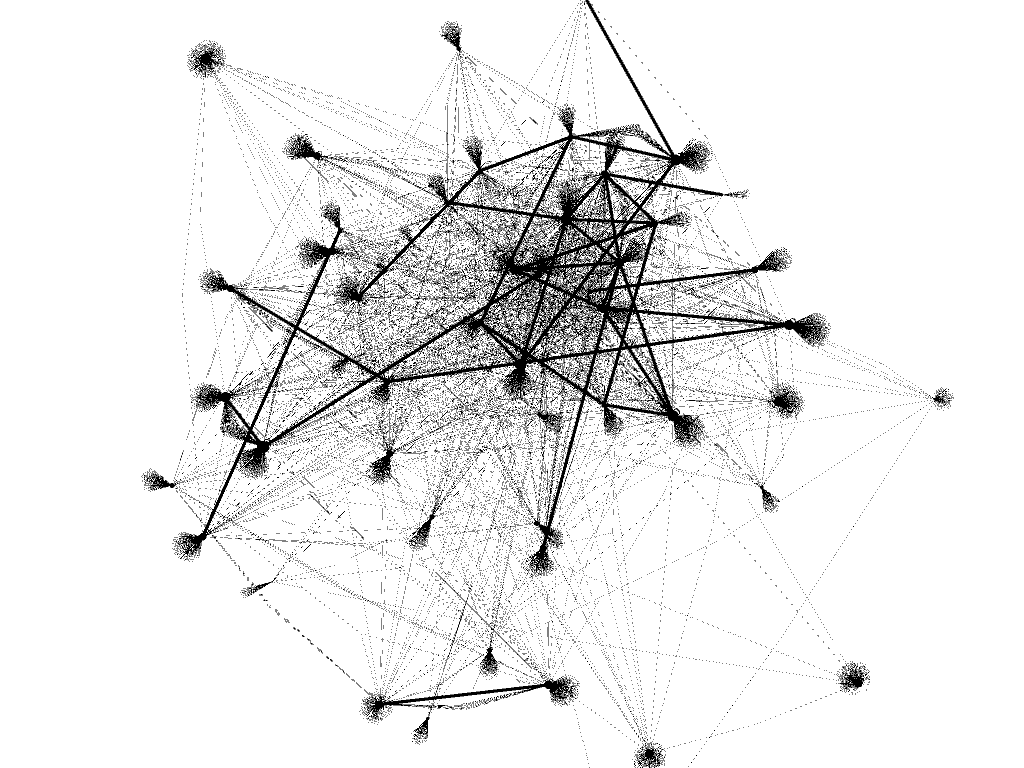

In [121]:
# это граф включает связи между членами сообщества и их друзьями, но не включает связи между друзьями
Image('screenshot_1.png', )

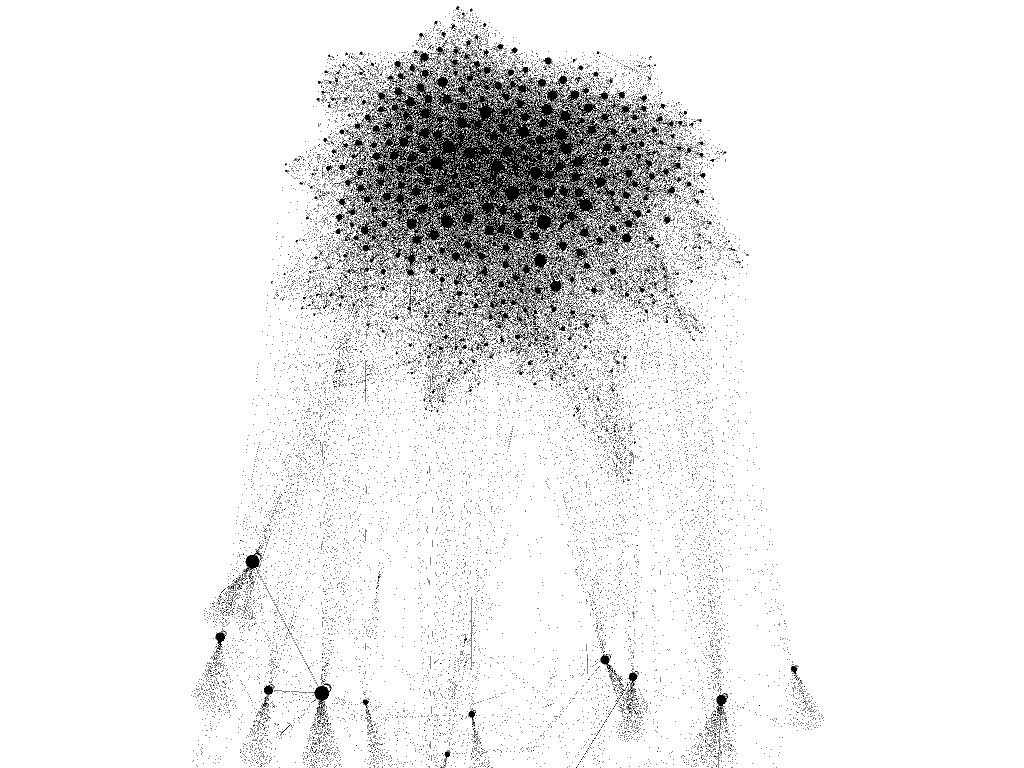

In [122]:
# это граф включает связи между членами сообщества и их друзьями, также включает связи между друзьями(верхнее облако)
# внизу друзья, которые оказались изолированы от других, так как в процессе получения связей между ними
# в какой то момент запросы закончились
# скорее всего большие точки - преимущественно члены сообщества, маленькие - друзья членов
Image('screenshot_2.png')

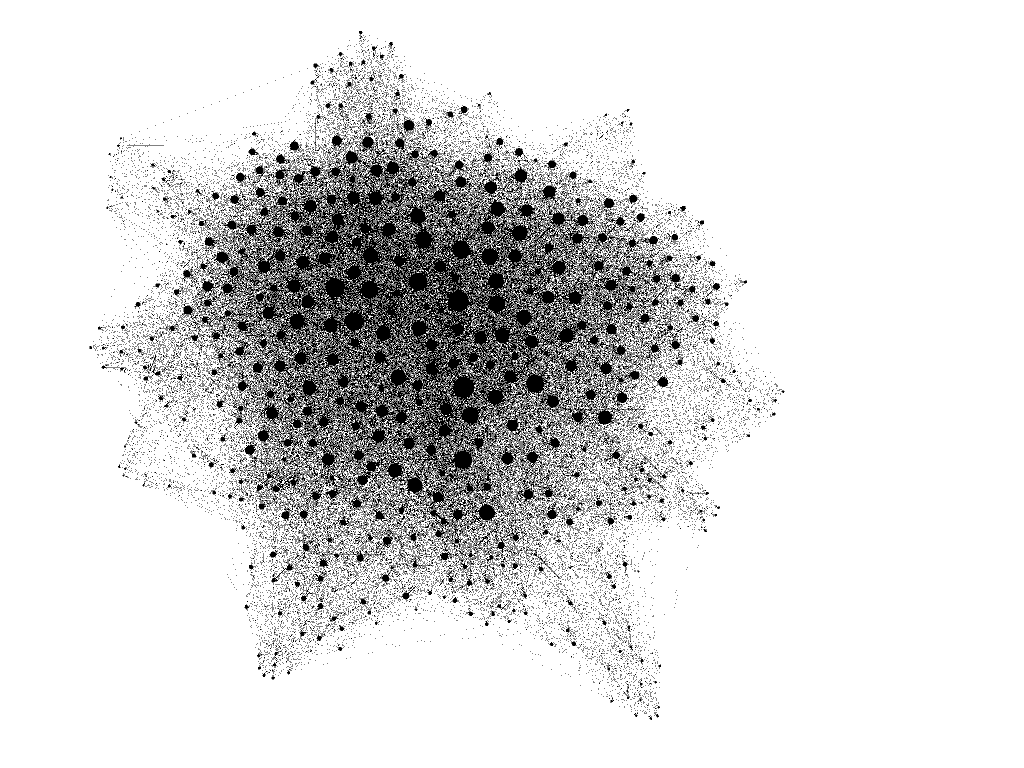

In [123]:
# убрал вершины для которых не получилось найти друзей в связи с ограничением запросов
# получается вот такой граф
Image('screenshot_clear.png', )

# Центральности вершин (2 балла)

Возможно, перед тем как пойти дальше, стоит немного почитстить граф - с помощью [kcore](https://www.google.com/search?client=firefox-b-d&q=networkx+kcore)

* Найдите наиболее влиятельные вершины с точки зрения degree, closeness и betweenness centrality
* Выделите их на картинке в gephi

In [124]:
g_clear = nx.read_gml('vk_clear.gml', label='id')

In [125]:
degree = nx.centrality.degree_centrality(g_clear)
clc = nx.centrality.closeness_centrality(g_clear)
btw = nx.centrality.betweenness_centrality(g_clear)

In [126]:
g_clear.number_of_nodes(), g_clear.number_of_edges()
# (497, 24886) ==> 497 << 24886

(497, 24886)

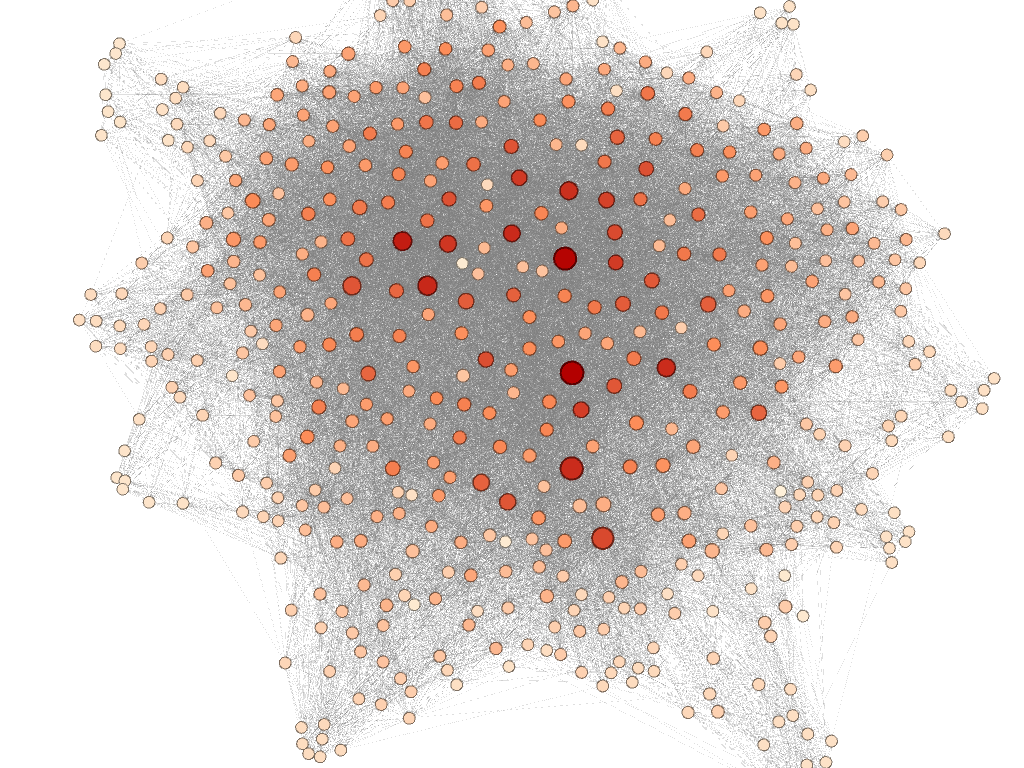

In [127]:
# degree
Image('screenshot_degree.png' )

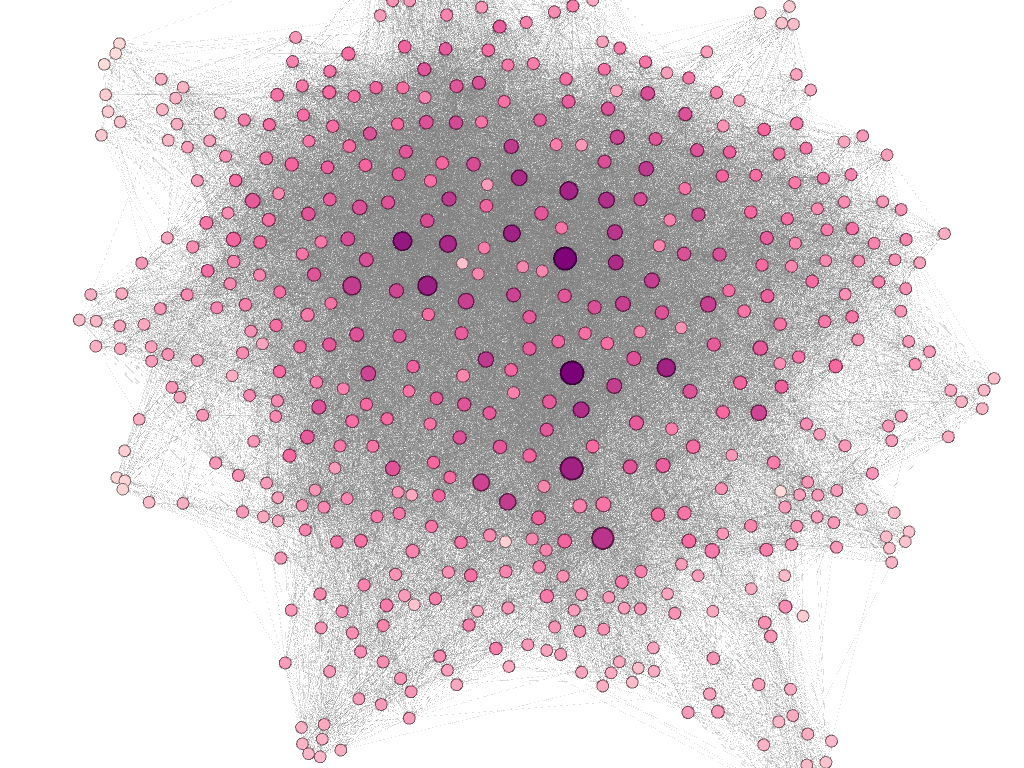

In [128]:
# closeness centrality
Image('screenshot_clc.png', )

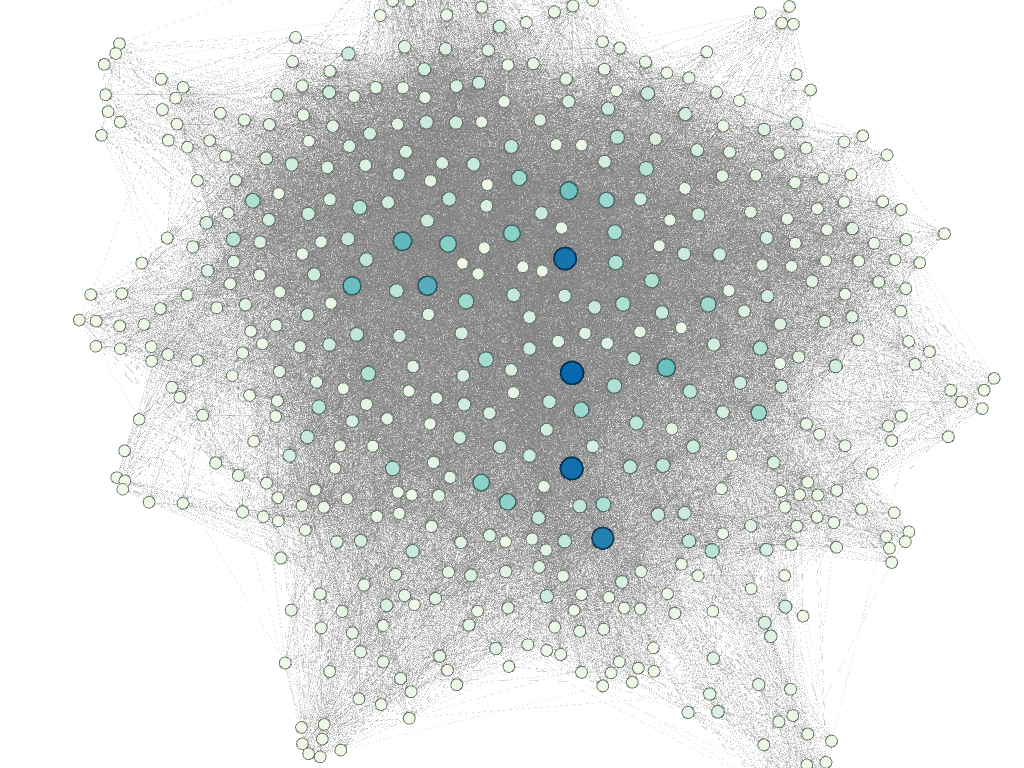

In [129]:
# betweenness centrality
Image('screenshot_btw.png', )

# Сообщества... в сообществе (2 балла)

В этом задании надо примерить 2 алгоритма выявления сообществ и сравнить их результаты

Выберите алгоритм выделения сообществ на графах, например
* label propagation или 
* алгоритм на основе edge betweeness

и алгоритм на основе похожести вершин, например 
* расчитатайте попарную похожесть по jaccard, косинусному расстоянию или корреляцию
* при необходимости переведите "похожесть" в "расстояние" (чем больше значение тем "дальше" объекты друг от друга)
* подайте матрицу попарных расстояний в алгоритм кластеризации, например в DBSCAN

Для обоих вариантов
* Выделите сообщества, опираясь на максимальное значение модулярности для полученного разбиения
* Изобразите граф с вершинами, раскрашенными в цвет своего сообщества в gephi
* Попробуйте проинтерпретировать полученные сообщества, кто эти люди, почему они связаны?
* Какой метод на ваш взгляд сработал лучше?

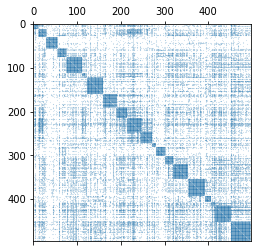

In [130]:
# матрица смежности графа
A = nx.adj_matrix(g_clear)
plt.spy(A, markersize=0.05)

In [131]:
# Попарная похожесть по Жаккару
jac = nx.jaccard_coefficient(g_clear)
jac = np.array(list(jac))

In [132]:
A.shape

(497, 497)

In [133]:
# матрица попарных расстояний
D = coo_matrix((jac[:,2], (jac[:,0], jac[:,1])), shape=(497, 497))

D = D+D.T

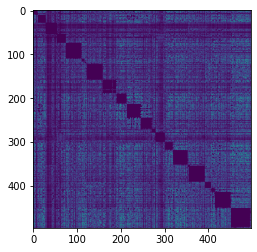

In [134]:
plt.imshow(D.toarray())

In [135]:
model = DBSCAN(metric='precomputed')
model.fit(D)

/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='precomputed',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [136]:
labels = model.labels_

In [137]:
true_labeling = np.array(list((nx.get_node_attributes(g_clear, 'label').values()))).astype('int')

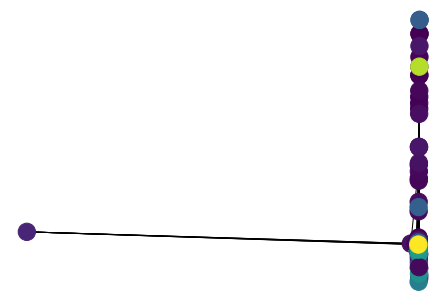

In [138]:
#с кластеризайией вышло сомнительно
layout = nx.layout.spectral_layout(g_clear)
nx.draw(g_clear, pos=layout, node_color=true_labeling,)

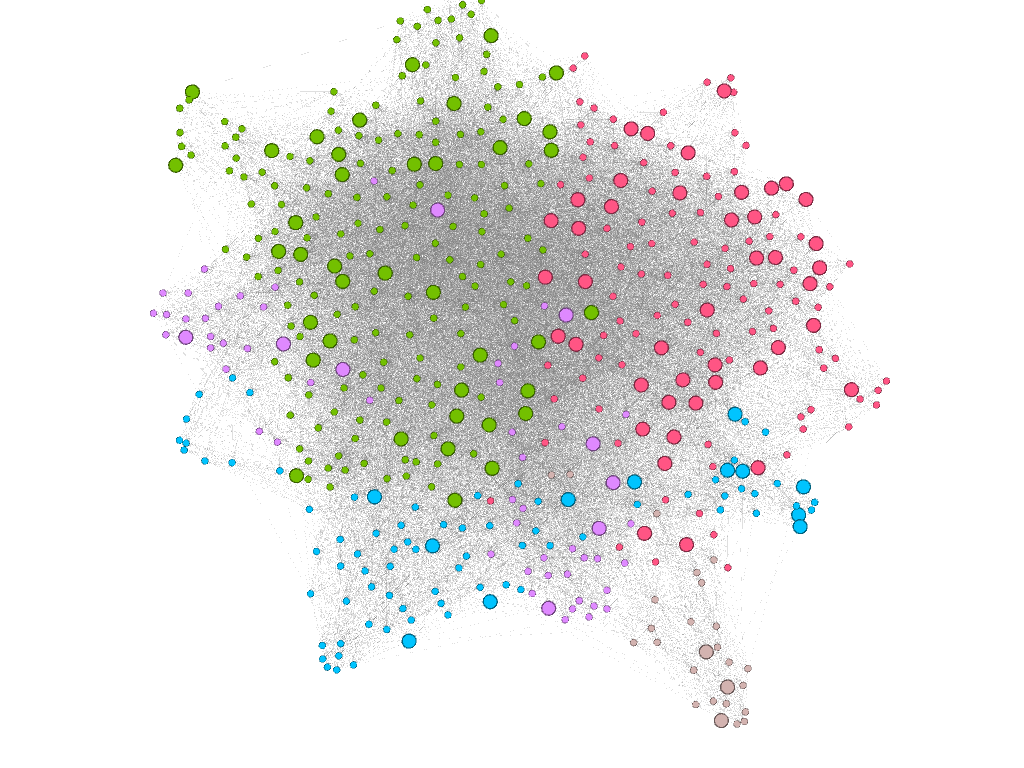

In [139]:
# Модулярность в Gephi
# скорее классами являются сообщества из разных факультетов, но преимущественно два факультета в группе ФФ, МеХМат 
Image('screenshot_modularity.png', )